In [36]:
import sys
import os
import yaml
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
import tensorflow as tf
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency
import keras 
import tensorflow.python.keras.backend as K
import copy

In [ ]:
!python3.8 -m pip list

In [ ]:
!python -m pip install keras==2.4.3 --user

In [ ]:
!pip install tensorflow==2.4.0 --user

In [ ]:
!python3.8 -m pip install keras==2.5.0rc0 --user

In [ ]:
import tensorflow as tf

In [ ]:
!python -m pip install keras --user

In [ ]:
!python3.8 -m pip install keras --user

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
import scipy.io as scio
temp=scio.loadmat('temp.mat')
best_hits_matrix_norm=temp['best_hits_matrix_norm']
pmm_best_hits_matrix_denorm=temp['pmm_best_hits_matrix_denorm']
input_times_grad(best_hits_matrix_norm[:,:,:,:], pmm_best_hits_matrix_denorm)

In [55]:
import scipy.io as scio
test = scio.loadmat('test_lead10_allIR_JuneJuly.mat')
test_data_scaled = test['test_data_scaled']
test_label = test['test_label'][:][0,:]

In [56]:
print(test_data_scaled.shape)
print(test_label.shape)

(13747, 32, 32, 7)
(13747,)


In [39]:
import scipy.io as scio
test = scio.loadmat('test_lead10_allIR.mat')
test_data_scaled = test['test_data_scaled']
test_label = test['test_label'][:][0,:]

In [6]:
import numpy as np
import scipy.io as scio
test = scio.loadmat('test_lead10_allIR_JuneJuly.mat')
test_data_scaled = test['test_data_scaled']
test_label = test['test_label'][0,:]

In [7]:
np.shape(test_label)

(13747,)

In [ ]:
    def KL(self, alpha):
        num_classes = 2 
        #print(alpha.shape)
        one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
        S = K.sum(alpha,axis=1,keepdims=True)  

        kl = self.lgamma(S) - K.sum(self.lgamma(alpha),axis=1,keepdims=True) +\
        K.sum(self.lgamma(one),axis=1,keepdims=True) - self.lgamma(K.sum(one,axis=1,keepdims=True)) +\
        K.sum((alpha - one)*(self.digamma(alpha)-self.digamma(S)),axis=1,keepdims=True)

        return kl
    
    def loss_func_CE(self, y_true, output):
        #Eqn 4: cross-entropy loss
        y_evidence = K.relu(output)
        alpha = y_evidence+1
        S = K.sum(alpha,axis=1,keepdims=True)
        A = K.sum(y_true * (self.digamma(S) - self.digamma(alpha)), axis=1, keepdims=True)
        A = K.sum(A)
        
        #print(self.current_epoch_num)
        #kl = K.sum(self.KL((1-y_true)*(alpha)+y_true))
        kl =  K.minimum(1.0, self.current_epoch_num/self.annealing_step) * K.sum(self.KL((1-y_true)*(alpha)+y_true))
        return A + kl

In [36]:
my_model_2 = tf.keras.models.load_model("goes16_resnet_gpus_01_baseline.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
my_model_2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 16)   1024        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d_18[0][0]                  
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 16)   0           bn_res_00_a[0][0]                
____________________________________________________________________________________________

In [5]:
import tensorflow as tf
my_model = tf.keras.models.load_model("goes16_resnet_gpus_01_echo.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
my_model.summary()

2022-08-13 00:33:59.435854: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-13 00:33:59.437382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-13 00:33:59.455455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-13 00:33:59.455499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-13 00:33:59.463045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-13 00:33:59.463127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

2022-08-13 00:33:59.887296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 00:33:59.887847: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-13 00:33:59.888855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-13 00:33:59.888926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-13 00:33:59.888976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49]

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 50)   3200        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 50)   200         conv2d_21[0][0]                  
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 50)   0           bn_res_00_a[0][0]                
____________________________________________________________________________________________

In [ ]:
def calc_prob_uncertinty(p):
  
    evidence = np.maximum(p[0], 0)

    alpha = evidence +1

    u = 2/ alpha.sum()
    prob = alpha[np.argmax(alpha)] / alpha.sum()
    return prob, u

In [119]:
from sklearn.metrics import roc_curve
fpr, tpr, thre = roc_curve(results_dict["true_labels"], results_dict["pred_conf"])

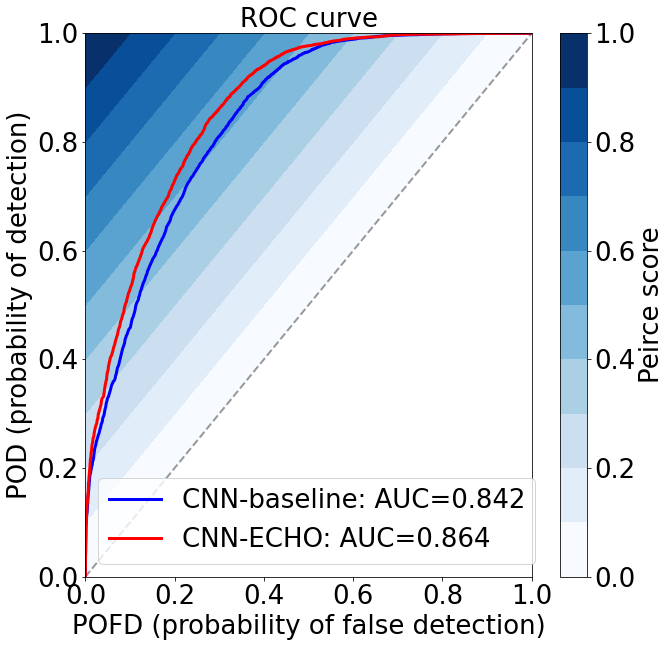

In [46]:
from module_4 import roc_curves_test5
AUC=roc_curves_test5.plot_roc_curve(test_label, preds_2, preds)
plt.title('ROC curve')
plt.savefig('plots/ROC_curve.png')

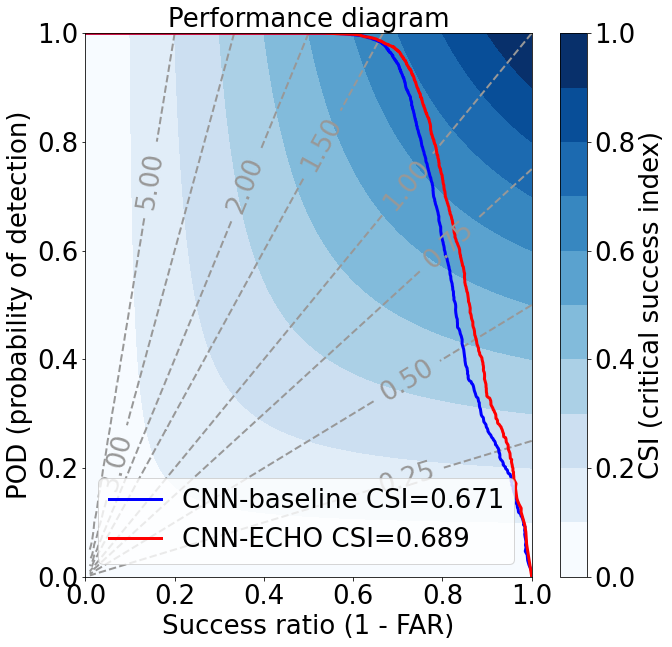

In [48]:
from module_4 import performance_diagrams_3
POD, CSI = performance_diagrams_3.plot_performance_diagram(test_label,preds_2,preds)
plt.title('Performance diagram')
plt.savefig('plots/Performance_diagram.png')

In [24]:
import sys
sys.path.append('/glade/work/fanda/util/course_repository/')
sys.path.append('/glade/work/fanda/util/course_repository/ai2es_xai_course/')
sys.path.append('/glade/work/fanda/util/ams-ml-python-course')
from module_4 import performance_diagrams_test
from module_4 import roc_curves
from module_4 import attributes_diagrams
from module_4 import utils
AUC=roc_curves.plot_roc_curve(test_label, preds_2)
print(AUC)
plt.title('ROC curve')

NameError: name 'preds_2' is not defined

In [27]:
CSI

array([0.        , 0.52476904, 0.53100147, ..., 0.9895288 ,        nan,
       1.        ])

Text(0.5, 1.0, 'Performance diagram')

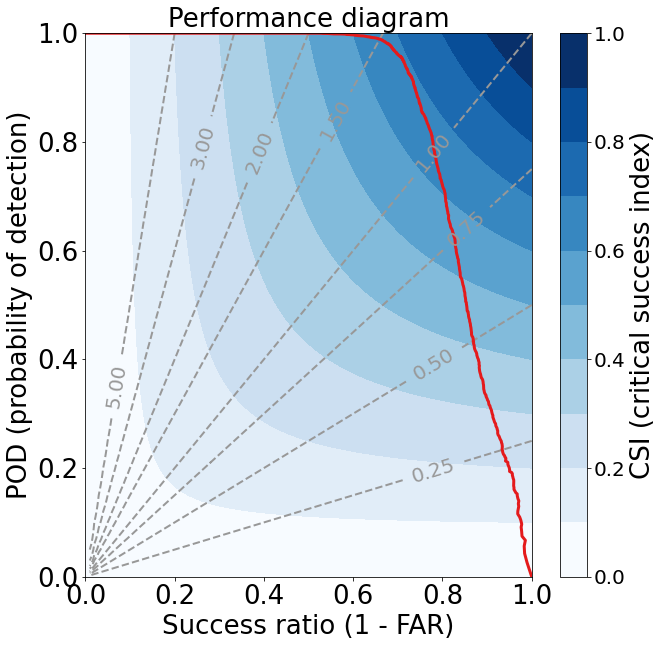

In [26]:
POD, CSI = performance_diagrams.plot_performance_diagram(test_label,preds)
plt.title('Performance diagram')

brier_skill_score: 0.38650314146852666


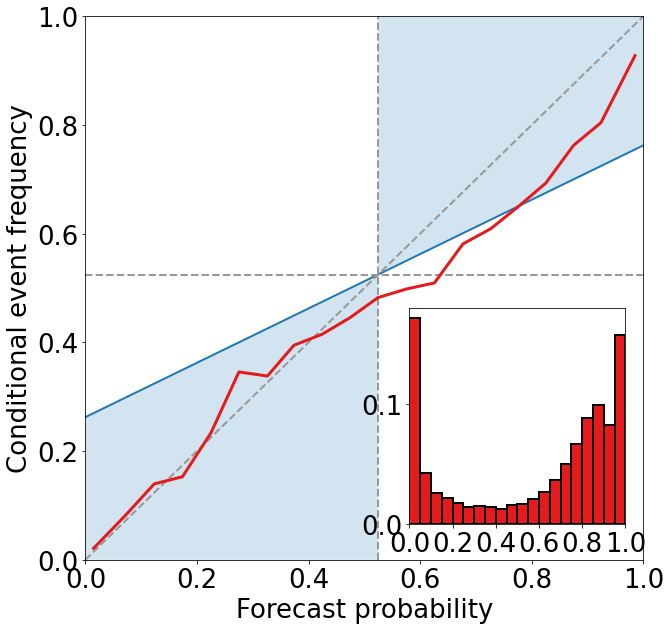

In [50]:
mean_forecast_by_bin, event_freq_by_bin, num_examples_by_bin=attributes_diagrams.plot_attributes_diagram(test_label,preds)
#print(a)
#plt.title('Attributes diagram')
#plt.savefig('plots/Attributes_diagram.png')
event_frequency = np.mean(test_label)
uncertainty = event_frequency * (1. - event_frequency)

this_numerator = np.nansum(
    num_examples_by_bin * (mean_forecast_by_bin - event_freq_by_bin) ** 2
)
reliability = this_numerator / np.sum(num_examples_by_bin)

this_numerator = np.nansum(
    num_examples_by_bin * (event_freq_by_bin - event_frequency) ** 2
)
resolution = this_numerator / np.sum(num_examples_by_bin)

# brier_score = uncertainty + reliability - resolution
brier_skill_score = (resolution - reliability) / uncertainty
print("brier_skill_score:",brier_skill_score)
plt.savefig('plots/Attributes_diagram_ECHO.png')

In [104]:
print(output[0:10,:])

[[9.9999881e-01 1.8650627e-06]
 [9.9932313e-01 3.8282163e-04]
 [9.9999976e-01 1.6993608e-08]
 [1.0000000e+00 5.2236855e-09]
 [8.3336318e-01 9.9457401e-01]
 [6.9916660e-01 9.9844581e-01]
 [4.2844436e-01 9.9870431e-01]
 [1.3434937e-03 9.9970609e-01]
 [5.0079085e-02 9.9966419e-01]
 [4.0972307e-01 9.9898368e-01]]


In [105]:
print(labels[0:10,:])

tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


In [106]:
print(label[0:10])

[0 1 0 0 1 1 1 1 1 0]


In [107]:
tf.expand_dims(label[0:10],-1)

<tf.Tensor: shape=(10, 1), dtype=int64, numpy=
array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]])>

In [93]:
np.min(confi)

0.53404254

In [ ]:
K.sum(alpha, axis=1, keepdims=True)

In [141]:
    results_dict["uncertainty"] = tf.concat(results_dict["uncertainty"], 0)
    results_dict["pred_probs"] = tf.concat(results_dict["pred_probs"], 0)
    results_dict["pred_labels"] = tf.concat(results_dict["pred_labels"], 0)
    results_dict["true_labels"] = tf.concat(results_dict["true_labels"], 0)

In [142]:
    results_dict["uncertainty"] = results_dict["uncertainty"][:, 0].cpu().numpy()
    results_dict["pred_conf"] =  np.max(results_dict["pred_probs"].cpu().numpy(), 1) #results_dict["pred_probs"].cpu().numpy() #np.max(results_dict["pred_probs"].cpu().numpy(), 1) #results_dict["pred_probs"][:,1].cpu().numpy() #np.max(results_dict["pred_probs"].cpu().numpy(), 1)
    results_dict["pred_labels"] = results_dict["pred_labels"][:, 0].cpu().numpy()
    results_dict["true_labels"] = results_dict["true_labels"][:, 0].cpu().numpy()#np.max(results_dict["true_labels"].cpu().numpy(), 1)

In [51]:
np.sum(results_dict["true_labels"]==results_dict["pred_labels"])/len(results_dict["pred_labels"])

0.7405448294102089

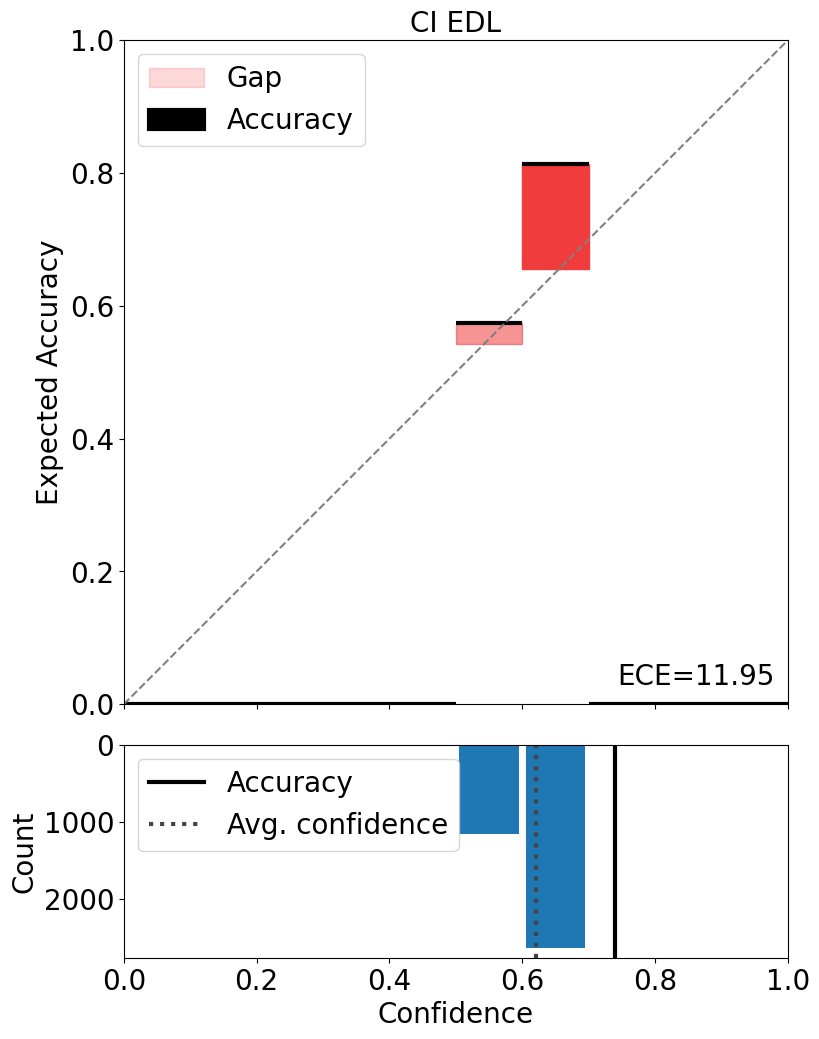

In [143]:
#cond = (test_data["true_labels"] == 0)
from application.reliability import reliability_diagram, reliability_diagrams, compute_calibration
title = "CI EDL"
fig = reliability_diagram(
    results_dict["true_labels"],#.numpy(), 
    results_dict["pred_labels"],#.numpy(), 
    results_dict["pred_conf"],#.numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(8, 8), dpi=100, 
    return_fig=True)

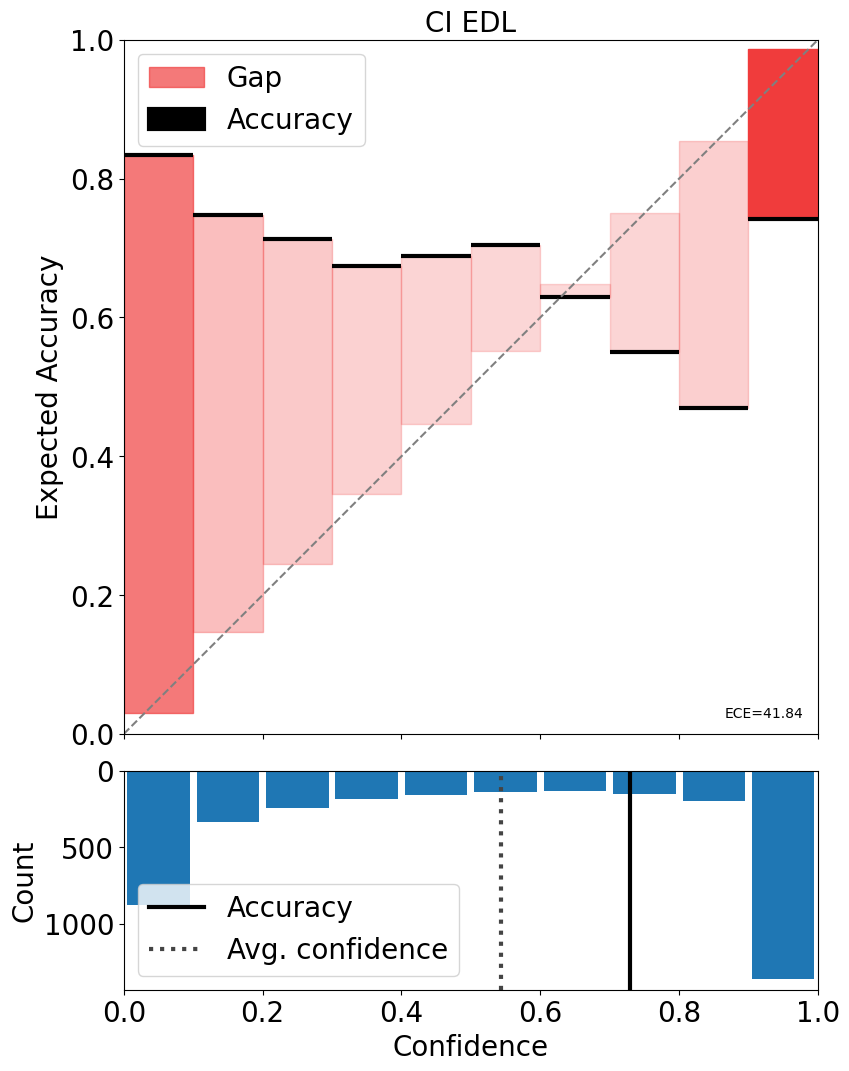

In [70]:
#cond = (test_data["true_labels"] == 0)
from application.reliability import reliability_diagram, reliability_diagrams, compute_calibration
title = "CI EDL"
fig = reliability_diagram(
    results_dict["true_labels"],#.numpy(), 
    results_dict["pred_labels"],#.numpy(), 
    results_dict["pred_conf"],#.numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(8, 8), dpi=100, 
    return_fig=True)

In [57]:
import shap
def m(X):
  return my_model.predict(X)

def explain_multiband(data, masker):
  # Initialize PartitionShap explainer
  explainer = shap.Explainer(m, masker)

  # Explain batch (calculate SHAP values)
  shap_values = explainer(data, max_evals=10000)

  return shap_values

In [162]:
preds.shape

(3781,)

In [172]:
test_label

[<class 'netCDF4._netCDF4.Variable'>
 float32 label(num)
 unlimited dimensions: num
 current shape = (427,)
 filling on, default _FillValue of 9.969209968386869e+36 used]

In [38]:
binary_threshold = 0.5
preds_2 = my_model_2.predict(test_data_scaled).reshape(test_label.shape)
binary_preds_2 = np.where(preds_2 >= binary_threshold, 1, 0)

In [58]:
# set the probability threshold for binary classification; predict on validation; add binary preds
#import keras
#my_model = keras.models.load_model("goes16ci_model_cpu_lead10_allIR.h5")#models/goes16ci_model_cpu2022-06-06 15:28:51.532054.h5")#"goes16ci_model_cpu_lead0_allIR.h5")
#my_model = tf.saved_model.load("/storage/home/dxf424/work/scrip/goes16ci_model_cpu_lead10_allIR.h5")
binary_threshold = 0.5
preds = my_model.predict(test_data_scaled).reshape(test_label.shape)
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [48]:
preds.shape

(3781,)

In [175]:
binary_preds

array([1, 1, 1, ..., 1, 1, 1])

In [21]:
my_model = utils.read_dense_net("goes16_resnet_gpus_01_echo.h5")
my_model.summary()

2022-08-09 23:48:38.965733: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-09 23:48:38.966360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-09 23:48:38.966427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-09 23:48:38.966475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-09 23:48:38.966488: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-09 23:48:38.966501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 58)   3712        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 58)   232         conv2d_6[0][0]                   
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 58)   0           bn_res_00_a[0][0]                
____________________________________________________________________________________________

In [31]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(F)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return POD, POFD, FAR, SR, CSI
#tn, fp, fn, tp
def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [32]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, binary_preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

RMSE: 0.39100000262260437
R squared: 0.413
Hellenger Distance: 0.455
2330
POD: 0.9121153313002495, POFD: 0.35665084953313947, FAR: 0.2615039281705948, SR: 0.7384960718294051, CSI:0.6894383906119028
Heidke Skill Score: 0.562
[[4203 2330]
 [ 634 6580]]
Pierce Skill Score: 0.555
Brier Score: 0.216
Brier Skill Score: 0.135
Accuracy score: 0.784
AUC: 0.864


In [73]:
top_2_idx = np.argsort(a)[-2:]
top_2_values = [a[i] for i in top_2_idx]

In [80]:
top_2_idx

array([1681, 1015])

In [87]:
a[0:100]

array([0.9043536 , 0.7295175 , 0.8872562 , 0.86782104, 0.62770075,
       0.99231887, 0.98860556, 0.63221294, 0.99001116, 0.8897629 ,
       0.8824918 , 0.92357934, 0.6890377 , 0.8678056 , 0.9486915 ,
       0.82762474, 0.9449576 , 0.7834903 , 0.90347934, 0.9970983 ,
       0.70641196, 0.77570176, 0.8977543 , 0.9999192 , 0.9658005 ,
       0.8794066 , 0.9995633 , 0.89218974, 0.99015665, 0.95509416,
       0.8912122 , 0.9887494 , 0.9846726 , 0.8059774 , 0.8605    ,
       0.9794367 , 0.9991241 , 0.8392968 , 0.9910069 , 0.84757406,
       0.99988973, 0.8515253 , 0.64392364, 0.9032001 , 0.99774605,
       0.8378061 , 0.95343584, 0.8878322 , 0.66946936, 0.98744595,
       0.88828367, 0.84877974, 0.6243929 , 0.79487014, 0.8919208 ,
       0.671632  , 0.9997402 , 0.9707549 , 0.82627946, 0.9548028 ,
       0.74478614, 0.8590454 , 0.90350914, 0.5864426 , 0.9998429 ,
       0.86656666, 0.92694384, 0.99253076, 0.8971662 , 0.85559446,
       0.94117564, 0.77096814, 0.7054999 , 0.8739413 , 0.85635

In [89]:
indices = (np.where((test_label==1) & (binary_preds==1)))[0]

In [150]:
preds[worst_miss_indices]

array([0.10198925, 0.10042125, 0.10007158, 0.09885567, 0.09642735,
       0.09541734, 0.09443524, 0.09434685, 0.0923207 , 0.09161571,
       0.09116091, 0.09110014, 0.09017453, 0.08954694, 0.08933167,
       0.08906669, 0.08882313, 0.08771334, 0.08769993, 0.08695144,
       0.0863645 , 0.0857933 , 0.08488374, 0.08413979, 0.08373603,
       0.08329247, 0.08242258, 0.07883158, 0.0761818 , 0.07428203,
       0.07404724, 0.07383214, 0.07292243, 0.07290629, 0.07249457,
       0.07036211, 0.0697281 , 0.06875854, 0.06866276, 0.06784275,
       0.06298169, 0.06227934, 0.06213909, 0.05996142, 0.05974495,
       0.05850582, 0.05763412, 0.0574571 , 0.05620994, 0.05530577,
       0.05204701, 0.04982699, 0.04913853, 0.04595388, 0.04534675,
       0.04491758, 0.04486644, 0.043961  , 0.04388667, 0.04359855,
       0.04297313, 0.04249918, 0.04223308, 0.04071016, 0.04000235,
       0.03974016, 0.0394339 , 0.03833044, 0.03731575, 0.03642976,
       0.03641842, 0.03635229, 0.03620453, 0.03611846, 0.03601

In [108]:
#print(preds[test_label==1])
#np.where((dists >= r) & (dists <= r + dr))
ind=[]
indices = (np.where((test_label==1) & (binary_preds==1)))[0]
ind = np.argsort(preds[indices])[-103:-3]
best_hit_indices = indices[ind]

indices = (np.where((test_label==0) & (binary_preds==1)))[0]
ind = np.argsort(preds[indices])[-100:]
worst_false_alarm_indices = indices[ind]

indices = (np.where((test_label==1) & (binary_preds==0)))[0]
ind = np.argsort(-preds[indices])[-101:-1]
worst_miss_indices = indices[ind]

indices = (np.where((test_label==0) & (binary_preds==0)))[0]
ind = np.argsort(-preds[indices])[-100:]
best_correct_null_indices = indices[ind]

print(indices.shape)
print(indices[ind])

(4203,)
[ 8527  3886  5123  5879  2420  5584  1105  6506 10266  9404  8366  3215
   880  8443  9860 12278 10078  9252  5182  7046  3558 12730  4125  3455
  3517  9674  2550  4459    98 11356 11232  4772 11103 13704 12815  8420
 10907  5976  5002  5535  7389   119  4583  1097  4019  8796  3968  3762
   160  3227  1246 12760  7797  8782  7851  7041  5511  1238 11967  9864
 10413  5067  4452  6145  8090 10443 11670  6908  6003    50  6555  3315
 11534  4345 11059  3054 10623 11834  9722  5572  7713 12689  4850   464
 11183  7137  1149  4310  6967  6447  4065  9583  1375 11727  1719  4486
 11186 10436  2528  8313]


In [72]:
a[0:100]

array([0.9043536 , 0.7295175 , 0.8872562 , 0.86782104, 0.62770075,
       0.99231887, 0.98860556, 0.63221294, 0.99001116, 0.8897629 ,
       0.8824918 , 0.92357934, 0.6890377 , 0.8678056 , 0.9486915 ,
       0.82762474, 0.9449576 , 0.7834903 , 0.90347934, 0.9970983 ,
       0.70641196, 0.77570176, 0.8977543 , 0.9999192 , 0.9658005 ,
       0.8794066 , 0.9995633 , 0.89218974, 0.99015665, 0.95509416,
       0.8912122 , 0.9887494 , 0.9846726 , 0.8059774 , 0.8605    ,
       0.9794367 , 0.9991241 , 0.8392968 , 0.9910069 , 0.84757406,
       0.99988973, 0.8515253 , 0.64392364, 0.9032001 , 0.99774605,
       0.8378061 , 0.95343584, 0.8878322 , 0.66946936, 0.98744595,
       0.88828367, 0.84877974, 0.6243929 , 0.79487014, 0.8919208 ,
       0.671632  , 0.9997402 , 0.9707549 , 0.82627946, 0.9548028 ,
       0.74478614, 0.8590454 , 0.90350914, 0.5864426 , 0.9998429 ,
       0.86656666, 0.92694384, 0.99253076, 0.8971662 , 0.85559446,
       0.94117564, 0.77096814, 0.7054999 , 0.8739413 , 0.85635

In [68]:
np.sum(np.isnan(test_data_scaled))

0

In [147]:
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_correct_null_indices])

best_hits_matrix_norm=test_data_scaled[best_hit_indices]
worst_false_alarm_matrix_norm=test_data_scaled[worst_false_alarm_indices]
worst_miss_matrix_norm=test_data_scaled[worst_miss_indices]
best_correct_null_matrix_norm=test_data_scaled[best_correct_null_indices]

In [60]:
best_correct_null_matrix_norm.shape

(10, 32, 32, 7)

In [ ]:
preds[indices[ind]]

In [53]:
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
best_hits_matrix_norm=test_data_scaled[best_hit_indices]
best_hits_matrix_norm=test_data_scaled[best_hit_indices]

In [ ]:
print(my_model.layers[-1].name)

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [9]:
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

In [19]:
import tensorflow.python.keras.backend as K
gradient_tensors = K.gradients(loss_tensor, input_tensors)

NameError: name 'loss_tensor' is not defined

In [24]:
print(my_model.layers[-1].name)
neuron_indices=np.array([0], dtype=int)
print(neuron_indices)
print(np.shape(best_hits_matrix_norm[0:101,:,:,:]))


activation_output
[0]
(100, 32, 32, 7)


In [35]:
np.shape(best_hits_matrix_norm)

(100, 32, 32, 7)

In [155]:
input_times_grad_matrix = input_times_grad(worst_miss_matrix_norm, pmm_worst_miss_matrix_denorm)#[0:101,:,:,:]

Have computed saliency maps for 0 of 100 examples...
Have computed saliency maps for all 100 examples!
(32, 32, 7)
(32, 32, 7)


In [157]:
import shap
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)
X = worst_miss_matrix_norm
#Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
#masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)

Partition explainer: 101it [03:39,  2.29s/it]                         


In [29]:
best_correct_null_matrix_norm.shape

(100, 32, 32, 7)

In [21]:
shap_values_pmm.shape

(32, 32, 7, 1)

0.002682680639815474
0.9158511825470977


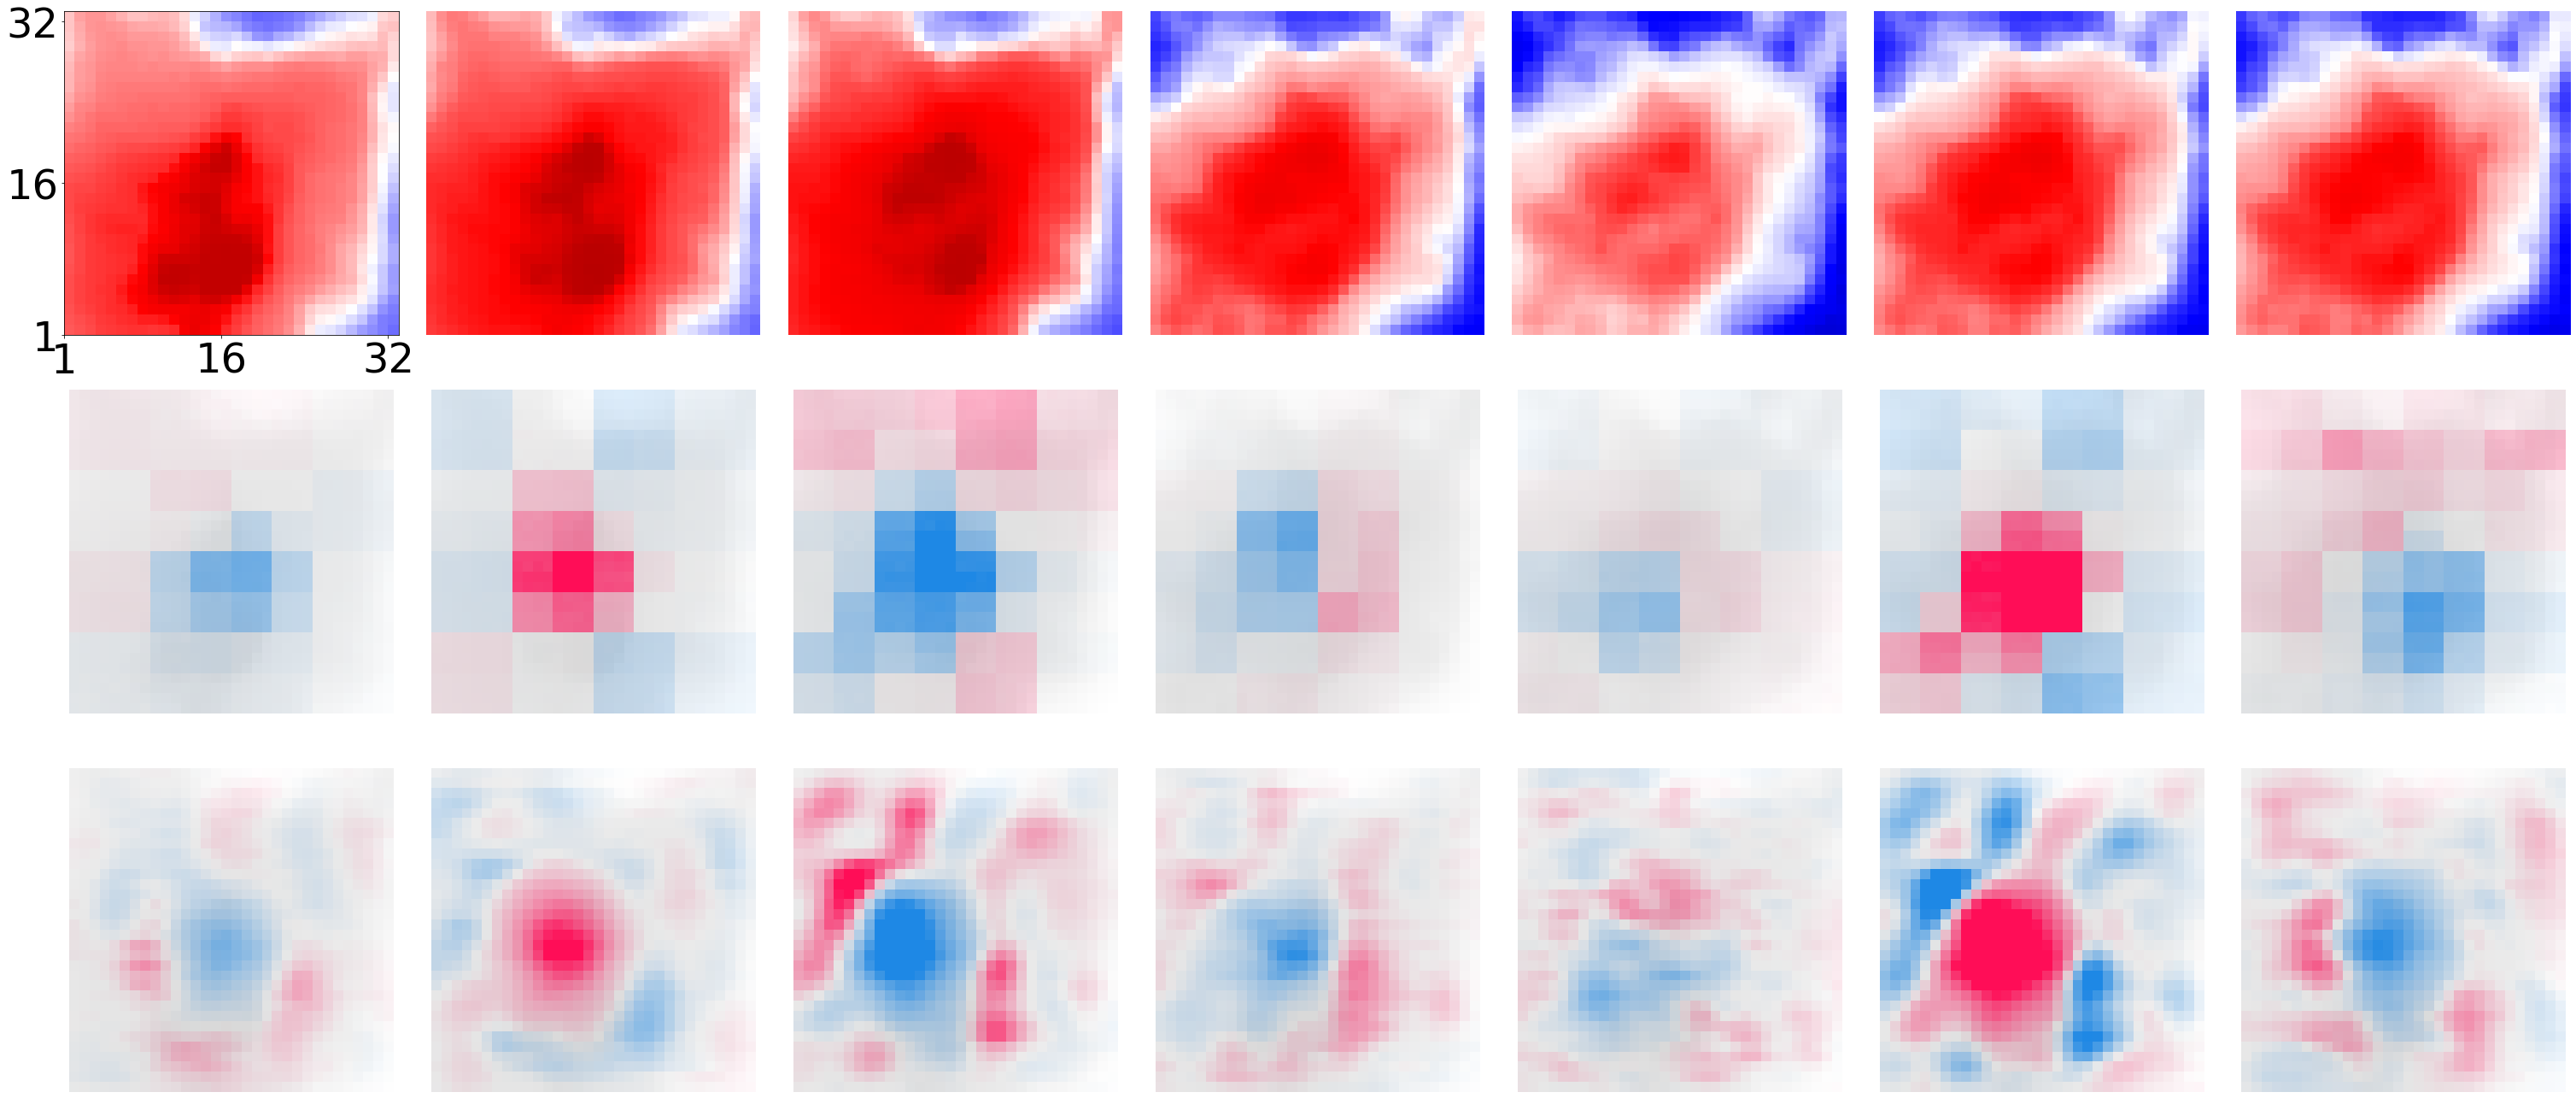

In [160]:
import copy 
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_xai(pmm_worst_miss_matrix_denorm,shap_values_pmm[:,:,:,0], input_times_grad_matrix)
plt.savefig('plots/Worst_MS_examples.png')
#plot_storm_xai_batch(np.expand_dims(pmm_best_correct_null_matrix_denorm, axis=0), 
#                      np.expand_dims(shap_values_pmm, axis=0))

In [ ]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [ ]:
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True)
#tf.config.run_functions_eagerly(True)
a=my_model.get_layer(name=my_model.layers[-1].name).output[..., 0] #.output[..., 1]

In [153]:
best_hits_matrix_norm.shape

(100, 32, 32, 7)

In [ ]:
import tensorflow as tf
tf.GradientTape

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [ ]:
!pip install h5py==2.10.0 --user yy

In [ ]:
print(1.dtype)

In [ ]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
import scipy.io as scio
scio.savemat('temp.mat',{'best_hits_matrix_norm':best_hits_matrix_norm, 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm})

In [ ]:
import scipy.io as scio
test=scio.loadmat('test.mat')
loss_tensor=test['loss_tensor']
input_tensors=test['input_tensors']


In [ ]:
print(input_tensors)

In [ ]:
#config = tf.compat.v1.ConfigProto
#import keras
#session = keras.backend.get_session()
#init = tf.global_variables_initializer()
#session.run(init)
#my_model = utils.read_dense_net("goes16ci_model_cpu_lead10_allIR.h5")
#my_model.summary()
#import tensorflow._api.v2.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()
#tf.disable_v2_behavior()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
import scipy.io as scio
temp=scio.loadmat('temp.mat')
best_hits_matrix_norm=temp['best_hits_matrix_norm']
pmm_best_hits_matrix_denorm=temp['pmm_best_hits_matrix_denorm']
input_times_grad(best_hits_matrix_norm[:,:,:,:], pmm_best_hits_matrix_denorm)

In [ ]:
print(my_model.input)

In [ ]:
tensor_train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(tensor_train_images)
    model.evaluate(x=tensor_train_images,y=train_labels, steps=10)
print(tape.gradient(model.total_loss,tensor_train_images))

In [ ]:
import tensorflow.python.keras.backend as K
loss=tf.convert_to_tensor([1], dtype=tf.float32)
var=tf.convert_to_tensor([2], dtype=tf.float32)
with tf.GradientTape() as tape:
    a=1
a=tape.gradient(loss, var)

In [ ]:
print(loss)

In [ ]:
best_hits_matrix_norm[0].shape

In [ ]:
with tf.GradientTape() as tape:
         print('ok')

In [ ]:
pmm_best_hits_matrix_denorm.shape

In [ ]:
!pip install tensorflow==2.4.0 --user

In [ ]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, binary_preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

In [ ]:
ch = np.arange(8,15)
print(ch)
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

In [ ]:
print(np.shape(test_data_scaled))

In [ ]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(my_model, [test_data_scaled, test_data_scaled])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([test_data_scaled[3,:,:,:]])
# plot the feature attributions
#shap.image_plot(shap_values, -test_data_scaled[100:105,:,:,:])

In [ ]:
!pip install tf-explain --user

In [ ]:
import shap
shap_values = shap.DeepExplainer(my_model).shap_values(test_data_scaled)
shap.summary_plot(shap_values, test_data_scaled, plot_type="bar")

In [ ]:
!pip install tensorflow==2.6.0 --user

In [ ]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(test_data_scaled, test_label),
        layers_name=["activation_1"],
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)


In [ ]:
def plot_storm_array(predictor_matrix, labels, contour=False):
    """Plots each channel of a storm-centered raster loaded from NetCDF file.
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param labels: C-length list of feature names to label each output. 
  """

    fig, ax = plt.subplots(1, len(labels), figsize=(15, 3))
    for i in range(len(labels)):

        # Contour plot
        if contour:
          a=ax[i].contourf(predictor_matrix[:,:,i])
          if i == 0:
            b=a
        # Image plot
        else:
          ax[i].imshow(predictor_matrix[:,:,i])
          ax[i].invert_yaxis()

        ax[i].set_title(labels[i])
        ax[i].axis('off')
    fig.colorbar(a, orientation='vertical')
print("Sample storm image:")
feature_names=['CH8','CH9','CH10','CH11','CH12','CH13','CH14',]
print(test_label[10])
plot_storm_array(test_data_scaled[10,:,:,:], labels=feature_names, contour=True)

In [ ]:
if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')
!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository

In [ ]:
!pip install dill --user

In [ ]:
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency

In [ ]:
import pythran
!cd course_repository; python setup.py install --user

In [ ]:
!pip install pythran --user

In [ ]:
print(image_utils.PREDICTOR_MATRIX_KEY)

In [ ]:
data = test_data_scaled
predictor_matrix_denorm = data[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = data[image_utils.PREDICTOR_NAMES_KEY]
predictor_matrix_norm = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

# Predict the first 5
preds = my_model.predict(predictor_matrix_norm[0][0:5,:])
print(preds)

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
grid = explainer.explain((test_data_scaled[1:3,:,:,:],None), my_model, class_index=1)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
test_data_scaled[1:5].shape

In [ ]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = test_data_scaled[np.random.choice(test_data_scaled.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(my_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(test_data_scaled[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -test_data_scaled[1:5])

In [ ]:
!pip install xgboost --user

In [ ]:
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
from tf_explain.callbacks.vanilla_gradients import VanillaGradientsCallback

model = [...]

callbacks = [
    VanillaGradientsCallback(
        validation_data=(test_data_scaled, test_label),
        class_index=0,
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)

In [ ]:
GOES-only(lead_time=10):POD: 0.8597816960537363, POFD: 0.587152516904583, FAR: 0.43284408751038495, SR: 0.567155912489615, CSI:0.5191381495564005

In [122]:
  print(np.shape(shap_values_pmm))
  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)

(32, 32, 7, 1)


In [159]:
import matplotlib

def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]
  print(np.shape(pmm_matrix_denorm))
  print(np.shape(input_times_grad_matrix))
        
  #plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)
  return input_times_grad_matrix

def plot_storm_xai(values, shap_values, input_times_grad_matrix):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(42, 18))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)
  print(max_val)
  input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)
  print(max_val_gi)
    
  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0][0].pcolormesh((1-values[:,:,0]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  #ax[0][0].axis('off')
  ax[0][0].set_xticks((0, 15, 31))
  ax[0][0].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][0].set_yticks((0, 15, 31))
  ax[0][0].set_yticklabels(('1', '16', '32'), fontsize=48)
#  ax[0][0].set_xticks([0,16,31])
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[0][1].pcolormesh((1-values[:,:,1]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None') 
  ax[0][1].set_xticks((0, 15, 31))
  ax[0][1].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][1].set_yticks((0, 15, 31))
  ax[0][1].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[0][2].pcolormesh((1-values[:,:,2]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][2].set_xticks((0, 15, 31))
  ax[0][2].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][2].set_yticks((0, 15, 31))
  ax[0][2].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[0][3].pcolormesh((1-values[:,:,3]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][3].set_xticks((0, 15, 31))
  ax[0][3].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][3].set_yticks((0, 15, 31))
  ax[0][3].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[0][4].pcolormesh((1-values[:,:,4]),
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][4].set_xticks((0, 15, 31))
  ax[0][4].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][4].set_yticks((0, 15, 31))
  ax[0][4].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[0][5].pcolormesh((1-values[:,:,5]), 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][5].set_xticks((0, 15, 31))
  ax[0][5].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][5].set_yticks((0, 15, 31))
  ax[0][5].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[0][6].pcolormesh((1-values[:,:,6]),
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
#  cbar = fig.colorbar(im, ax=ax[0][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[0][6].set_xticks((0, 15, 31))
  ax[0][6].set_xticklabels(('1', '16', '32'), fontsize=48)
  ax[0][6].set_yticks((0, 15, 31))
  ax[0][6].set_yticklabels(('1', '16', '32'), fontsize=48)
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  im = ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [147]:
import matplotlib

def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  print('ok')
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]

  plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)

def plot_storm_xai(values, shap_values, input_times_grad_matrix):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(42, 18))#56, 18)

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)
  
  input_times_grad_matrix = copy.deepcopy(input_times_grad_matrix)
  input_times_grad_matrix = np.squeeze(input_times_grad_matrix)
  abs_vals_gi = np.abs(input_times_grad_matrix.sum(-1))
  max_val_gi = np.nanpercentile(abs_vals_gi, 99.9)

  # Reflectivity
  #ax[0][0].set_title("CH8 BT")
  im = ax[0][0].pcolormesh((1-values[:,:,0])*df.loc[0,"range"]+df.loc[0,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[0,"min"],
                      vmax=df.loc[0,"max"],
                      shading="flat", edgecolors='None')
  cbar = fig.colorbar(im, ax=ax[0][0])
  cbar.ax.tick_params(labelsize=36)
  #cax = divider.append_axes('right', size='5%', pad=0.05)
  #im = ax.imshow(data, cmap='bone')
  #fig.colorbar(im, ax=ax[0][0])
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][0].imshow(input_times_grad_matrix[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  #ax[0][1].set_title("CH9 BT")
  im = ax[0][1].pcolormesh((1-values[:,:,1])*df.loc[1,"range"]+df.loc[1,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[1,"min"],
                      vmax=df.loc[1,"max"],
                      shading="flat", edgecolors='None') 
  cbar = fig.colorbar(im, ax=ax[0][1])
  cbar.ax.tick_params(labelsize=36)
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][1].imshow(input_times_grad_matrix[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  #ax[0][2].set_title("CH10 BT")
  im = ax[0][2].pcolormesh((1-values[:,:,2])*df.loc[2,"range"]+df.loc[2,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[2,"min"],
                      vmax=df.loc[2,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][2])
  cbar.ax.tick_params(labelsize=36)
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][2].imshow(input_times_grad_matrix[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  #ax[0][3].set_title("CH11 BT")
  im = ax[0][3].pcolormesh((1-values[:,:,3])*df.loc[3,"range"]+df.loc[3,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[3,"min"],
                      vmax=df.loc[3,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][3])
  cbar.ax.tick_params(labelsize=36)
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][3].imshow(input_times_grad_matrix[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  #ax[0][4].set_title("CH12 BT")
  im = ax[0][4].pcolormesh((1-values[:,:,4])*df.loc[4,"range"]+df.loc[4,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[4,"min"],
                      vmax=df.loc[4,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][4])
  cbar.ax.tick_params(labelsize=36)
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][4].imshow(input_times_grad_matrix[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  #ax[0][5].set_title("CH13 BT")
  im = ax[0][5].pcolormesh((1-values[:,:,5])*df.loc[5,"range"]+df.loc[5,"min"], 
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[5,"min"],
                      vmax=df.loc[5,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][5])
  cbar.ax.tick_params(labelsize=36)
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][5].imshow(input_times_grad_matrix[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi)   
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  #ax[0][6].set_title("CH14 BT")
  im = ax[0][6].pcolormesh((1-values[:,:,6])*df.loc[6,"range"]+df.loc[6,"min"],
                      cmap='seismic',
                      norm=None,
                      vmin=df.loc[6,"min"],
                      vmax=df.loc[6,"max"],
                      shading="flat", edgecolors='None')  
  cbar = fig.colorbar(im, ax=ax[0][6])
  cbar.ax.tick_params(labelsize=36)
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  im = ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  #cbar = fig.colorbar(im, ax=ax[1][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[2][6].imshow(input_times_grad_matrix[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val_gi, vmax=max_val_gi) 
  #cbar = fig.colorbar(im, ax=ax[2][6])
  #cbar.ax.tick_params(labelsize=36)
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [52]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
test_dir = My_dir+'test/'
onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0:
        delete_row.append(i)
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    test.append(processed_file.variables['predictor'])
    test_label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    date_1.append(processed_file.variables['date'])
    Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0:
        delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
print(np.shape(all_images))
print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]
config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(test_data))

float32
(56647, 32, 32, 57)
(13747, 32, 32, 57)
(40000, 32, 32, 7)
(13747, 32, 32, 7)


In [105]:
scaler.scale_values.loc[0,"min"]

,min,max,range
0,196.240356,256.515930,60.275574
1,192.958588,266.010223,73.051636
2,193.739899,273.079498,79.339600
3,191.657227,319.518921,127.861694
4,214.358093,281.906372,67.548279
5,191.948639,325.856934,133.908295
6,191.283997,326.021210,134.737213


In [99]:
scaler.scale_values.to_pickle("minmax_value.h5")

In [101]:
df = pd.read_pickle("minmax_value.h5")

In [104]:
df.loc[0,"min"]

196.2403564453125

In [166]:
binary_preds
preds
test_labels

(3781,)

In [176]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 49.0
latS = 33.0
lonW = -90.0
lonE = -105.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [184]:
preds

array([0.9867133 , 0.66981226, 0.83119214, ..., 0.76482046, 0.8129695 ,
       0.81609416], dtype=float32)

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

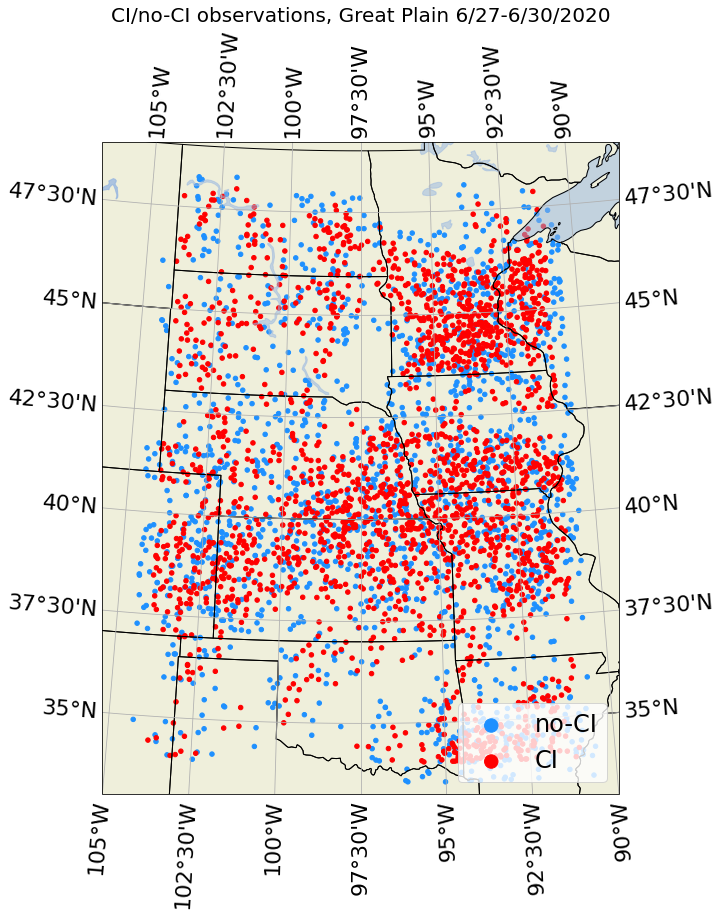

In [182]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [78]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
'''
for i in range(2):
    color=pd.DataFrame()
    color['color'] = test_label[test_label==i]
    ax.scatter(lon_0[test_label == i]-360,
               lat_0[test_label == i],
               c=color['color'].map(colors),
               s=20, transform=ccrs.PlateCarree())
'''
im = ax.scatter(lon_0-360, lat_0, c=preds, s=50, marker="s", cmap='Greens',transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax)
    
plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

NameError: name 'ccrs' is not defined

In [65]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.0
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'black'} #{0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [56]:
from datetime import datetime,timedelta
date_time=[]
for i in range(len(date_0)):
    date_time.append(datetime.fromtimestamp(date_0[i]))

In [57]:
date_start = datetime(2020, 7, 22, 3, 0)

date_end = datetime(2020, 7, 22, 4, 0)

index = []
for i in range(len(date_time)):
    if(date_time[i]>date_start and date_time[i]<date_end):
        index.append(i)

In [233]:
l

Text(0.5, 1.0, 'CI/no-CI observations, Great Plain 6/27-6/30/2020')

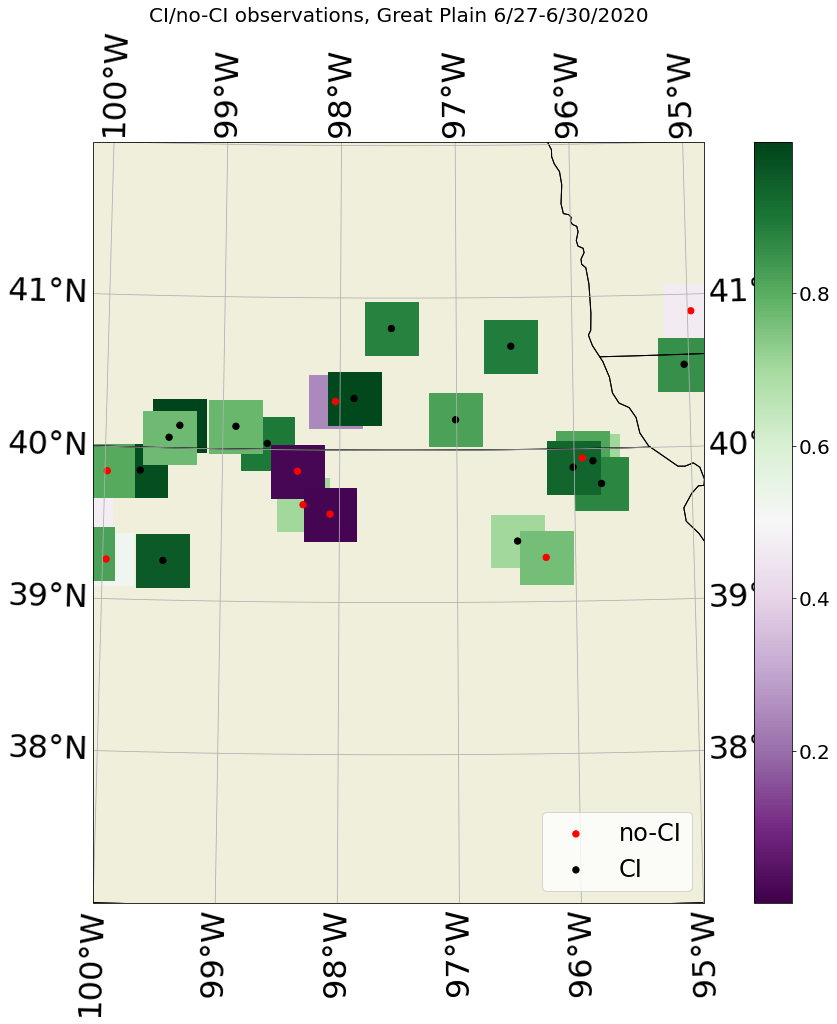

In [ ]:

%matplotlib inline
plt.rcParams['font.size'] = '32'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 14))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

l = []
im = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_')
plt.colorbar(im,ax=ax)
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    l.append(ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=40, transform=ccrs.PlateCarree()))

plt.legend((l[0],l[1]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [338]:
np.array((lon_0[index]-360, lat_0[index])).T.shape

(61, 2)

In [325]:
np.hstack(1,2)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [153]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'red', 1:'blue'} 

In [120]:
color['color'].map(colors)

0    blue
1    blue
2    blue
3    blue
4     red
5    blue
6    blue
7     red
Name: color, dtype: object

In [133]:
selected_label==selected_preds 

masked_array(data=[False,  True,  True, False,  True,  True,  True,  True,
                   False,  True,  True, False,  True, False,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                   False,  True,  True,  True, False,  True,  True,  True,
                    True,  True,  True,  True,  True, False,  True],
             mask=False,
       fill_value=True)

In [134]:
selected_label[selected_label==selected_preds ]

masked_array(data=[1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
                   0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
                   1., 1., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [154]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=-preds[index]*np.log(preds[index]), s=4500, marker="s", cmap='Greys',transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    selected_preds=binary_preds[index]
    if i == 0:
        index_2 = selected_label==selected_preds 
        color['color'] = np.ones(np.sum(index_2))
    else:
        index_2 = selected_label==(1-selected_preds)
        color['color'] = np.zeros(np.sum(index_2))
    #color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors),
               s=350, transform=ccrs.PlateCarree(), edgecolors='k')
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["Correct", "Incorrect"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 7/27-7/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(-preds[index]*np.log(preds[index]))
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        selected_preds=binary_preds[index]
        if i == 0:
            index_2 = selected_label==selected_preds        
        else:
            index_2 = selected_label==(1-selected_preds)
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=False)
from IPython.display import HTML
HTML(ani.to_jshtml())
#f = "animation.mp4" 
#writervideo = FFMpegWriter(fps=60) 

ani.save("plots/Uncertainty_animation.gif", writer='imagemagick')
#ani.save('test.gif')
#plt.show()
#plt.close()

<IPython.core.display.Javascript object>

In [145]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 36.5
latS = 33.0
lonW = -95.0
lonE = -98.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'white', 1:'black'} 

In [146]:
import matplotlib.pyplot as plt
import matplotlib.colors as pycolors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = pycolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greens')
new_cmap = truncate_colormap(cmap, 0, 0.8)

In [122]:
color['color'].map(colors)

0     red
1     red
2     red
3     red
4     red
5     red
6     red
7     red
8     red
9     red
10    red
11    red
12    red
13    red
14    red
15    red
16    red
17    red
18    red
19    red
20    red
21    red
Name: color, dtype: object

In [147]:
%matplotlib notebook
# Enable interactive plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.ticker as mticker

plt.rcParams['font.size'] = '28'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-98, -97, -96, -95])
gl.ylocator = mticker.FixedLocator([34, 35, 36])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))
lines = []
a1 = ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=4500, marker="s", cmap=new_cmap,transform=ccrs.PlateCarree(),label='_nolegend_')
lines.append(a1)
#
for i in range(2):
    color=pd.DataFrame()
    selected_label=test_label[index]
    index_2 = selected_label==i
    color['color'] = selected_label[index_2]
    a = ax.scatter(lon_0[index][index_2]-360,
               lat_0[index][index_2],
               c=color['color'].map(colors), edgecolors='k',
               s=350, transform=ccrs.PlateCarree())
    lines.append(a)
plt.colorbar(lines[0],ax=ax,fraction=0.0518, pad=0.2)
plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
timetext = plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=32)


def animate(i, lon_0, lat_0, preds, lines):
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    '''
    lines.append(ax.scatter(lon_0[index]-360, lat_0[index], c=preds[index], s=2800, marker="s", cmap='PRGn',transform=ccrs.PlateCarree(),label='_nolegend_'))
    plt.colorbar(lines[0],ax=ax)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        lines.append(ax.scatter(lon_0[index][index_2]-360,
                   lat_0[index][index_2],
                   c=color['color'].map(colors),
                   s=40, transform=ccrs.PlateCarree()))
    plt.legend((lines[1],lines[2]),colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=1, loc="lower right")
    plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)
    '''
    lines[0].set_offsets(np.array((lon_0[index]-360, lat_0[index])).T)
    lines[0].set_array(preds[index])
    
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        #lines[i+1].set_array(color['color'].map(colors))#,
        lines[i+1].set_offsets(np.array((lon_0[index][index_2]-360, lat_0[index][index_2])).T)
                   #c=color['color'].map(colors),
                   #s=40, transform=ccrs.PlateCarree()))
    timetext.set_text(str(date_start)[5:]+" — "+str(date_end)[-8:])
    return lines, timetext, #a1, lines[1], lines[2],
    #return line1,


ani = FuncAnimation(fig, animate, frames=range(8),
                    interval=2000, fargs=(lon_0, lat_0, preds, lines), repeat=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save("plots/Performance_animation.gif", writer='imagemagick')

<IPython.core.display.Javascript object>

In [151]:
    i = 1
    date_start = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*i)
    date_end = datetime(2020, 7, 28, 18, 40)+timedelta(minutes=20*(i+1))
    index = []
    for i in range(len(date_time)):
        if(date_time[i]>date_start and date_time[i]<date_end):
            index.append(i)
    for i in range(2):
        color=pd.DataFrame()
        selected_label=test_label[index]
        index_2 = selected_label==i
        color['color'] = selected_label[index_2]
        print(np.array((lon_0[index][index_2], lat_0[index][index_2])).T)
        print(preds[index][index_2])

[[ -97.01   38.02]
 [-103.78   38.93]
 [-104.47   43.42]
 [ -94.11   37.29]
 [ -97.61   35.86]
 [ -97.97   38.02]
 [-102.47   44.17]
 [-104.13   39.71]
 [ -97.39   35.82]
 [ -96.43   36.3 ]
 [ -95.07   37.77]
 [ -98.65   34.83]
 [-100.49   44.14]
 [ -98.65   35.31]
 [ -99.25   36.63]]
[3.6738902e-02 3.5272956e-06 7.7791341e-02 5.6578975e-02 7.1378022e-01
 1.4334278e-01 3.1157397e-02 3.0715019e-01 5.5106634e-01 1.5606333e-02
 4.6328819e-01 5.9752469e-03 4.6846010e-03 7.1673002e-03 7.1942598e-02]
[[ -94.59   37.29]
 [ -98.77   36.15]
 [ -91.47   43.16]
 [-102.95   43.69]
 [ -98.09   36.34]
 [ -97.49   38.02]
 [-103.99   43.9 ]
 [-103.9    43.82]
 [ -96.91   35.82]
 [-103.51   44.2 ]
 [ -95.34   38.44]
 [ -99.13   35.31]
 [ -92.97   37.68]
 [-103.65   40.19]]
[0.8525863  0.99547416 0.9992034  0.93070865 0.95269024 0.9260094
 0.8854356  0.85927474 0.6411229  0.79916304 0.93605775 0.989031
 0.97400767 0.6777331 ]


In [274]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>